In [32]:
import torch 
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import os
from glob import glob
from PIL import Image

In [33]:
df_data = pd.read_csv("HAM10000_metadata")
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


In [34]:

img_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob((os.path.join('*', '*.jpg')))}

df_data['img_path'] = df_data['image_id'].map(img_path.get)

#drop rows with no image path
df_data.dropna(inplace=True)
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,img_path
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,HAM10000_images_part_2\ISIC_0031633.jpg
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,HAM10000_images_part_1\ISIC_0025837.jpg


In [35]:
def load_image(image_path):
    try:
        image = Image.open(image_path)
        return np.asarray(image.resize((32, 32)))
    except Exception as e:
        print(f"Error loading image '{image_path}': {e}")
        return None

In [36]:
df_data['img'] = df_data['img_path'].map(load_image)
df_data.dropna()
df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,img_path,img
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1\ISIC_0025030.jpg,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1\ISIC_0026769.jpg,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,HAM10000_images_part_1\ISIC_0025661.jpg,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,HAM10000_images_part_2\ISIC_0031633.jpg,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,vidir_modern,HAM10000_images_part_1\ISIC_0025837.jpg,"[[[122, 82, 82], [158, 109, 112], [179, 120, 1..."


In [72]:
print(df_data.shape)
print(df_data['img'].iloc[10].shape)

(8039, 10)
(32, 32, 3)


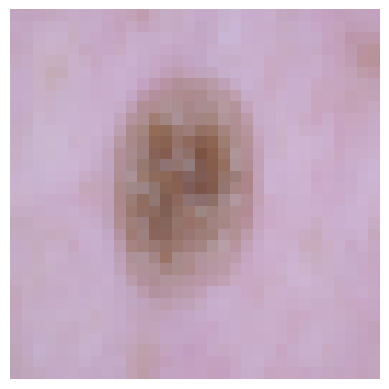

In [73]:
plt.imshow(df_data['img'].iloc[10], cmap = "Greys_r")
plt.gca().axis("off")
plt.show()

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_data[['lesion_id', 'img']], df_data['dx'], test_size=0.2, random_state=42)
X_train

,lesion_id,img
1156,HAM_0000827,"[[[168, 127, 129], [176, 136, 143], [178, 135,..."
373,HAM_0001389,"[[[140, 117, 129], [148, 126, 137], [154, 132,..."
5382,HAM_0002885,"[[[242, 169, 181], [234, 159, 169], [240, 165,..."
6162,HAM_0002309,"[[[232, 146, 157], [233, 145, 157], [236, 146,..."
7735,HAM_0006567,"[[[183, 164, 175], [182, 164, 175], [184, 165,..."
...,...,...
6604,HAM_0003747,"[[[225, 137, 148], [225, 138, 149], [223, 133,..."
6832,HAM_0000464,"[[[160, 128, 138], [165, 132, 143], [169, 136,..."
1081,HAM_0003715,"[[[215, 147, 140], [218, 149, 142], [220, 152,..."
9457,HAM_0000675,"[[[164, 136, 147], [168, 140, 153], [172, 144,..."


In [82]:
n, p = X_train.shape[0], X_train.shape[1] - 1

img_tensors = [torch.Tensor(img) for img in X_train['img'].values]
X_train['img_tensor'] = img_tensors

X_train_flat = torch.stack([img.flatten() for img in X_train['img_tensor']])
X_train_flat.shape

torch.Size([6431, 3072])

In [83]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
f = LR.fit(X_train_flat, y_train)

c:\Users\Zoe Greenwald\anaconda3\envs\ml-0451-2\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [84]:
LR.score(X_train_flat, y_train)

0.7019126107914788